In [ ]:
# E1: A perceptron is a neural network with a single layer of input linear neurons followed by an output unit based on the sign(x) function.
# E2: Single layer Preceptron: single layer of input linear neurons, similar to linear models without specific peculiarities
#     Multilayer Preceptron: contains a hidden layer, there are two weight matrices. Ingeneral, hidden layers have non-linear activation functions
# E3: hard-margin refers to the fitting of a model with zero errors
# E4: e
# E5: e

In [1]:
import boto3
import pandas as pd; pd.set_option('display.max_columns', 100)
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score

s3 = boto3.resource('s3')
bucket_name = 'grant-gonnerman-data-445'
bucket = s3.Bucket(bucket_name)

file_key = 'framingham.csv'

bucket_object = bucket.Object(file_key)
file_object = bucket_object.get()
file_content_stream = file_object.get('Body')

# reading data file
heart = pd.read_csv(file_content_stream)
heart.head()

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,4.0,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,2.0,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1.0,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,3.0,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,3.0,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0


In [2]:
# removing NA 
heart = heart.dropna()

In [ ]:
# defining input and target variables 
x = heart[['age', 'currentSmoker', 'totChol', 'BMI', 'heartRate' ]]
y = heart['TenYearCHD']

# lists to store 
md1_results = list()
md2_results = list()
md3_results = list()
md4_results = list()

for i in range(1,100):
    # spliting the data 
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, stratify = y)

    # scaling the data
    scaler = MinMaxScaler()
    x_train = pd.DataFrame(scaler.fit_transform(x_train), columns = x_train.columns)
    x_test = pd.DataFrame(scaler.fit_transform(x_test), columns = x_train.columns)

    ### Model 1 ###
    # defining the first MLP model 
    md1 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(4, input_dim = 5, activation = 'tanh'),
    tf.keras.layers.Dense(2, activation = 'softmax')
    ])
    md1.compile(optimizer = 'sgd', loss = 'categorical_crossentropy', metrics = ['accuracy'])
    md1.fit(x_train, tf.keras.utils.to_categorical(y_train, num_classes = 2), epochs = 100, batch_size = 500,
        validation_data = (x_test, tf.keras.utils.to_categorical(y_test,num_classes = 2)))
    # predicting on test data
    md1_pred = md1.predict(x_test)[:,1]
    #changing likilyhood to label 
    md1_label = np.where(md1_pred < .15, 0, 1)
    # computing recall
    md1_recall = recall_score(y_test, md1_label)
    md1_results.append(md1_recall)

    ### Model 2 ###
    # defining the second MLP model 
    md2 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(4, input_dim = 5, activation = 'relu'),
    tf.keras.layers.Dense(2, activation = 'softmax')
    ])
    md2.compile(optimizer = 'sgd', loss = 'categorical_crossentropy', metrics = ['accuracy'])
    md2.fit(x_train, tf.keras.utils.to_categorical(y_train, num_classes = 2), epochs = 100, batch_size = 500,
            validation_data = (x_test, tf.keras.utils.to_categorical(y_test,num_classes = 2)))
    # predicting on test data
    md2_pred = md2.predict(x_test)[:,1]
    #changing likilyhood to label 
    md2_label = np.where(md2_pred < .15, 0, 1)
    # computing recall
    md2_recall = recall_score(y_test, md2_label)
    md2_results.append(md2_recall)

    ### Model 3 ###
    # building the svm model
    md3 = SVC(kernel = 'rbf', probability = True).fit(x_train, y_train)
    # predicting on test
    md3_pred = md3.predict_proba(x_test)[:,1]
    # likilyhoods to labels
    md3_label = np.where(md3_pred < .15, 0, 1)
    # computing recall
    md3_recall = recall_score(y_test, md3_label)
    md3_results.append(md3_recall)

    ### Model 4 ###
    # building second svm model
    md4 = SVC(kernel = 'poly', probability = True).fit(x_train, y_train)
    # predicting on test
    md4_pred = md4.predict_proba(x_test)[:,1]
    # likilyhoods to labels
    md4_label = np.where(md4_pred < .15, 0, 1)
    # computing recall
    md4_recall = recall_score(y_test, md4_label)
    md4_results.append(md4_recall)

2022-10-28 23:08:36.911797: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-10-28 23:08:36.911870: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ip-172-16-65-168.ec2.internal): /proc/driver/nvidia/version does not exist
2022-10-28 23:08:36.912440: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/100
6/6 [==============================] - 1s 36ms/step - loss: 0.7033 - accuracy: 0.5130 - val_loss: 0.6412 - val_accuracy: 0.6052
Epoch 2/100
6/6 [==============================] - 0s 10ms/step - loss: 0.6569 - accuracy: 0.5523 - val_loss: 0.6019 - val_accuracy: 0.6858
Epoch 3/100
6/6 [==============================] - 0s 6ms/step - loss: 0.6189 - accuracy: 0.6320 - val_loss: 0.5699 - val_accuracy: 0.7486
Epoch 4/100
6/6 [==============================] - 0s 7ms/step - loss: 0.5879 - accuracy: 0.7312 - val_loss: 0.5443 - val_accuracy: 0.7937
Epoch 5/100
6/6 [==============================] - 0s 8ms/step - loss: 0.5626 - accuracy: 0.8078 - val_loss: 0.5235 - val_accuracy: 0.8306
Epoch 6/100
6/6 [==============================] - 0s 7ms/step - loss: 0.5418 - accuracy: 0.8379 - val_loss: 0.5066 - val_accuracy: 0.8443
Epoch 7/100
6/6 [==============================] - 0s 6ms/step - loss: 0.5246 - accuracy: 0.8458 - val_loss: 0.4929 - val_accuracy: 0.8470
Epoch 8/100
6/6 [========

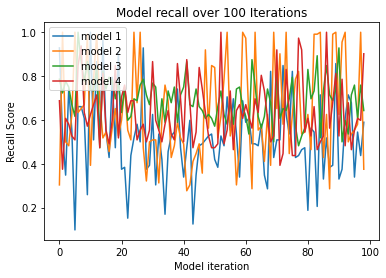

In [11]:
plt.plot(md1_results)
plt.plot(md2_results)
plt.plot(md3_results)
plt.plot(md4_results)
plt.legend(["model 1", "model 2","model 3", "model 4"], loc = "upper left")
plt.title("Model recall over 100 Iterations")
plt.xlabel("Model iteration")
plt.ylabel("Recall Score")
plt.show()

In [12]:
print('average recall of model 1:', np.mean(md1_results))
print('average recall of model 2:', np.mean(md2_results))
print('average recall of model 3:', np.mean(md3_results))
print('average recall of model 4:', np.mean(md4_results))

average recall of model 1: 0.5218253968253969
average recall of model 2: 0.63997113997114
average recall of model 3: 0.6934523809523809
average recall of model 4: 0.6295093795093795


In [ ]:
# based on the results I would choose model 3 because it had the highest recall on average